In [1]:
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype

In [2]:
import scipy.stats as stats
from scipy.stats import ttest_ind, f_oneway
import statsmodels.api as sm

In [3]:
df = pd.read_parquet("clean_data_funnel.parquet")

In [4]:
df.to_excel("clean_data_funnel.xlsx")

In [5]:
# Pivot the DataFrame to track the statuses for each transaction_id
pivot_df = df.pivot_table(index='transaction_id', columns='transaction_type', values='num_count', aggfunc='size', fill_value=0)

# Define the funnel stages
funnel_stages = ['select', 'init', 'confirm']

In [6]:
# Check how many transactions successfully transition through each stage
def check_progression(row, stages):
    for stage in stages:
        if row.get(stage, 0) == 0:
            return False
    return True

pivot_df['progression'] = pivot_df.apply(lambda row: check_progression(row, funnel_stages), axis=1)

# Count transactions at each stage
stage_counts = {stage: pivot_df[pivot_df[stage] > 0].shape[0] for stage in funnel_stages}
completed_transactions = pivot_df['progression'].sum()

# Identify drop-off points
drop_offs = {stage: stage_counts[funnel_stages[i]] - stage_counts[funnel_stages[i+1]] for i, stage in enumerate(funnel_stages[:-1])}

In [7]:
# Merge the pivoted data back with the original DataFrame to access additional columns
merged_df = df.merge(pivot_df.reset_index(), on='transaction_id')

In [8]:
merged_df.head(5)

,bpp_id,bap_id,transaction_type,transaction_id,num_count,select_timestamp,std_code,provider_name,provider_id,segment_key,confirm,init,on_confirm,on_init,on_select,select,progression
0,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,on_select,0001e709-5ed3-436c-8f34-c04c27174ca5,8,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,2,2,2,2,2,2,True
1,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,confirm,0001e709-5ed3-436c-8f34-c04c27174ca5,1,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,2,2,2,2,2,2,True
2,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,select,0001e709-5ed3-436c-8f34-c04c27174ca5,8,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,2,2,2,2,2,2,True
3,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,on_init,0001e709-5ed3-436c-8f34-c04c27174ca5,2,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,2,2,2,2,2,2,True
4,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,init,0001e709-5ed3-436c-8f34-c04c27174ca5,2,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,2,2,2,2,2,2,True


In [9]:
# Analyze transactions that did not progress to the next stage
non_progressing_transactions = merged_df[~merged_df['progression']]

# Example: Check for common providers in dropped transactions
common_providers = non_progressing_transactions['provider_name'].value_counts()

# Output the results
print(f"Number of transactions that progressed through all stages: {completed_transactions}")
print(f"Number of transactions at each stage: {stage_counts}")

Number of transactions that progressed through all stages: 20564
Number of transactions at each stage: {'select': 24894, 'init': 22145, 'confirm': 20564}


<Axes: >

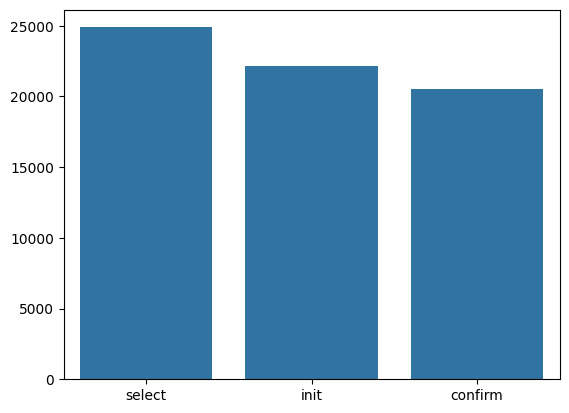

In [10]:
sns.barplot(stage_counts)

In [11]:
print(f"Drop-offs at each stage: {drop_offs}")

Drop-offs at each stage: {'select': 2749, 'init': 1581}


<Axes: >

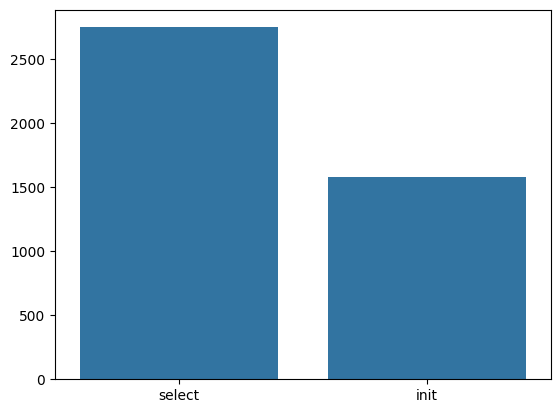

In [12]:
sns.barplot(drop_offs)

In [13]:
# Chi-Squared Test for provider_name
contingency_table = pd.crosstab(df['provider_name'], df['transaction_type'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-squared test for provider_name: p-value = {p}")

# Chi-Squared Test for location (std_code)
contingency_table_location = pd.crosstab(df['std_code'], df['transaction_type'])
chi2_location, p_location, dof_location, expected_location = stats.chi2_contingency(contingency_table_location)
print(f"Chi-squared test for location (std_code): p-value = {p_location}")

Chi-squared test for provider_name: p-value = 1.0
Chi-squared test for location (std_code): p-value = 0.005152272764557423


Chi-Squared Test: 
	
	The p-value is less than 0.05, it suggests a significant association between the categorical variable (e.g., provider, location) and the transaction progression.


In [14]:
# Convert timestamps to numerical values
df['select_hour'] = pd.to_datetime(df['select_timestamp']).dt.hour

In [15]:
def day_period(hour):
  if hour > 5.00 and hour <= 12.00:
    return "Morning"
  elif hour > 12.00 and hour <= 18.00:
    return "Afternoon"
  elif hour > 18.00 and hour <=23.00:
    return "Evening"
  else:
    return "Late_Night"

In [16]:
df["Hour_of_day"] = df["select_hour"].apply(day_period)

In [17]:
df.head(5)

,bpp_id,bap_id,transaction_type,transaction_id,num_count,select_timestamp,std_code,provider_name,provider_id,segment_key,select_hour,Hour_of_day
0,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,on_select,0001e709-5ed3-436c-8f34-c04c27174ca5,8,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,22.0,Evening
1,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,confirm,0001e709-5ed3-436c-8f34-c04c27174ca5,1,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,22.0,Evening
2,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,select,0001e709-5ed3-436c-8f34-c04c27174ca5,8,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,22.0,Evening
3,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,on_init,0001e709-5ed3-436c-8f34-c04c27174ca5,2,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,22.0,Evening
4,webapi.magicpin.in/oms_partner/ondc,ondc-bap.olacabs.com,init,0001e709-5ed3-436c-8f34-c04c27174ca5,2,2024-05-29T22:38:52Z,std:080,Wow! Momo,46315883,0001e709-5ed3-436c-8f34-c04c27174ca5__46315883,22.0,Evening


In [18]:
hr_of_day = CategoricalDtype(["Morning","Afternoon","Evening","Late_Night"], ordered=True)

In [19]:
df["Hour_of_day"] = df["Hour_of_day"].astype(hr_of_day)

In [20]:
day_period_crosstab = pd.crosstab(columns=df["transaction_type"],index= df["Hour_of_day"])

In [21]:
day_period_crosstab.drop(columns=["on_confirm","on_init","on_select"], inplace=True)

In [22]:
day_period_crosstab

transaction_type,confirm,init,select
Hour_of_day,,,
Morning,6962,7699,11375
Afternoon,20265,22520,33076
Evening,26292,29245,46156
Late_Night,2308,2775,6310


<Axes: xlabel='Hour_of_day'>

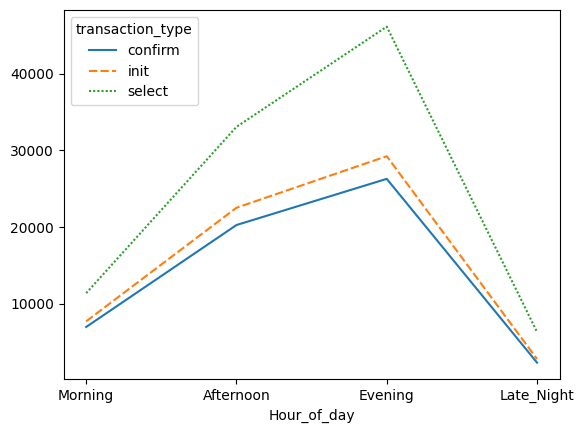

In [24]:
sns.lineplot(day_period_crosstab)

In [25]:
# T-Test for comparing hours between two groups (e.g., 'select' and 'confirm')
select_hours = df[df['transaction_type'] == 'select']['select_hour']
confirm_hours = df[df['transaction_type'] == 'confirm']['select_hour']

t_stat, p_val = ttest_ind(select_hours, confirm_hours)
print(f"T-Test between 'select' and 'confirm' transaction hours: p-value = {p_val}")

# ANOVA for comparing hours across multiple groups
init_hours = df[df['transaction_type'] == 'init']['select_hour']

f_stat, p_val = f_oneway(select_hours, init_hours, confirm_hours)
print(f"ANOVA for transaction hours: p-value = {p_val}")

T-Test between 'select' and 'confirm' transaction hours: p-value = 9.089762095367694e-16
ANOVA for transaction hours: p-value = 1.1237075664892776e-18


T-Test / ANOVA: 
	
	A p-value less than 0.05 indicates a significant difference in the means between groups.